<h1 style="display: flex; align-items: center; justify-content: space-between;">
  Music Information Retrieval
  <img src="https://www.upf.edu/documents/8071534/8177261/MTG_logo-07.png/c5d8ed89-90cf-7fbb-6116-1ab41706aa85?t=1578480743718"
       alt="MTG logo"
       width="180"
       style="vertical-align: middle; margin-left: 20px;" />
</h1>

This notebook is part of the **Music Information Retrieval (MIR)** course within the  
[**Sound and Music Computing (SMC)**](https://www.upf.edu/web/smc) programme  
at the **Music Technology Group (MTG), Universitat Pompeu Fabra**.

---

### How to Run the Notebook
You can download the notebook and run it locally on your computer.

Alternatively, to access some GPU time for free, open it directly in **Google Colab** using the badge below:

<a target="_blank"
   href="https://colab.research.google.com/github/mrocamora/mir_course/blob/main/notebooks/MIR_course-sound_classification_shallow_pipeline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg"
       alt="Open in Colab" />
</a>

---

## Homework 1



**Instructions:**

1. Complete parts 1 through 6, filling in code in the `utils.py` file where indicated **# YOUR CODE HERE** or responses in `this notebook` where marked with **# YOUR RESPONSE HERE** or **# YOUR CODE HERE**.
2. **Document** your code. Add comments explaining what the different parts of your code are doing.
3. If you copy code from external resources (e.g. librosa's examples), include references as comments.
4. When finished, commit and push this completed notebook file along with the `utils.py` file to your GitHub repository corresponding to this homework.
5. IMPORTANT: do not modify any of the provided code.

**How to work with the `utils.py` file and Google Colab:**

You can run your code remotely with Google Colab if you add the `utils.py` file to your files' folder (search for the folder icon in the menu on the left). But **CAREFUL**, you should copy any changes you make to `utils.py` in Colab to a local copy. Each time you re-start a session the changes of any file in the files folder are lost.

**Grading:**

- This homework is worth 15 points.
- Each function you code in `utils.py` is worth 1 point, for a total of 7 points.
- Each answer in part 5 is worth 1 point, for a total of 3 points.
- Part 6 is worth 5 points, 2 points for discussing and 3 points for experimenting with some of the ideas you propose.
- Points will be automatically assigned when passing tests, and manually assigned when it comes to your written responses.

**Academic integrity:**

Remember that this homework should be authored by you only. It's ok to discuss with classmates but you have to submit your own original solution.

---



# Sound Classification for Mridangam Stroke Recognition
### End-to-end classification using deep learning on the mel-spectrogram

In this homework, we will explore stroke type classification of the mrdingdam dataset. We will pursue a deep learning based approach. Pre-processing the audio into mel-spectograms and classifying with a convolutional neural network

The mrdringam is a double sided drum used in Carnatic music.

For a good introduction to the mrdringam and carnatic instrumentation more generally please take a look at the https://mtg.github.io/IAM-tutorial-ismir22/indian_art_music/carnatic-music.html#carnatic-instrumentation, the section on mrdingdam https://mtg.github.io/IAM-tutorial-ismir22/indian_art_music/carnatic-music.html#percussion-in-performance.

extra info on mrdingdam
https://planetmridangam.tripod.com/index.html

## Setup environment

### Installation of packages

First of all we need to find out if the notebook is run on Colab and, if so, what version of cuda we have on the server. 

In [96]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  !nvcc -V

Then we install the pytorch version for the corresponding cuda version and the other packages.

In [ ]:
# !pip install torch torchaudio # Removed torch vision as it's not needed
!pip install torchaudio
!pip install torchmetrics # https://lightning.ai/docs/torchmetrics/stable/#install-torchmetrics
!pip install lightning
!pip install mirdata scikit-learn

In [ ]:
!pip install torch torchaudio --index-url https://download.pytorch.org/whl/cpu

In [19]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.6 MB/s  0:00:00 eta 0:00:01


### Import packages

We import the packages and we set the random_seed for our experiments. The random seed makes sure the experiment is reproducible on this environment.

We use mirdata to load the datasets, sklearn for data partitioning, torchaudio to load and transform audio files, and pytorch lightning on top of pytorch for machine learning. 

In [ ]:
import mirdata
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import seaborn as sns

# import sklearn.model_selection
# import random
import torch
import torchaudio
import lightning.pytorch as pl
import torchmetrics

# Set random seed for reproducibility
RANDOM_SEED=0
from lightning.pytorch import seed_everything
seed_everything(seed=RANDOM_SEED, workers=True)

Seed set to 0


0

## Part 1 - Preparing the Data

We initialize Mridangam stroke a collection of 7162 audio examples of individual strokes of the Mridangam in various tonics. The dataset comprises of 10 different strokes played on Mridangams with 6 different tonic values. 

In this experiment we predict the 10 stroke classes. 



In [98]:
mridangam = mirdata.initialize("mridangam_stroke")

First time the dataset needs to be downloaded. This is fairly easy with the public datasets in mirdata, by calling the download method. 

In [4]:
mridangam.download()

In [4]:
mridangam.validate()  # validate dataset

100%|██████████| 6976/6976 [00:02<00:00, 2378.44it/s]


({'tracks': {}}, {'tracks': {}})

### Inspect the data

In [ ]:
track = mridangam.choice_track()  # load a random track
x, sr = track.audio
ipd.Audio(track.audio_path)
print(track)  # see what data a track contains
ipd.Audio(x, rate=sr) # Listen to the audio

Track(
  audio_path="/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/E/231180__akshaylaya__thom-e-077.wav",
  stroke_name="thom",
  tonic="E",
  track_id="231180",
  audio: The track's audio

        Returns,
)


Lets listen to an example of each stroke in the same tonic to get an understanding of the audio we are working with.

In [ ]:
# from collections import defaultdict

# # Get one random example per stroke and display an audio player for each

# stroke_map = defaultdict(list)
# for tid in mridangam.track_ids:
#   t = mridangam.track(tid)
#   stroke_map[t.stroke_name].append(tid)

# for stroke in sorted(stroke_map.keys()):
#   choice = np.random.choice(stroke_map[stroke])
#   track = mridangam.track(choice)
#   x, sr = track.audio
#   print(f"{stroke} — track_id: {choice} — tonic: {track.tonic}")
#   display(ipd.Audio(x, rate=sr))

from collections import defaultdict

stroke_map = defaultdict(list)
for tid in mridangam.track_ids:
    t = mridangam.track(tid)
    stroke_map[t.stroke_name].append(tid)

# Choose a single random tonic for all displayed examples
all_tonics = [mridangam.track(tid).tonic for tid in mridangam.track_ids]
unique_tonics = sorted(list(set(all_tonics)))
chosen_tonic = np.random.choice(unique_tonics)
print(f"Chosen tonic for this run: {chosen_tonic}")

for stroke in sorted(stroke_map.keys()):
    # Filter candidates to those with the chosen tonic
    candidates = [tid for tid in stroke_map[stroke] if mridangam.track(tid).tonic == chosen_tonic]
    if len(candidates) == 0:
        # Fallback to any random example of the stroke if none match the chosen tonic
        choice = np.random.choice(stroke_map[stroke])
        print(f"{stroke} — no example with tonic {chosen_tonic}, fallback to track_id: {choice} — tonic: {mridangam.track(choice).tonic}")
    else:
        choice = np.random.choice(candidates)
        print(f"{stroke} — track_id: {choice} — tonic: {chosen_tonic}")
    track = mridangam.track(choice)
    x, sr = track.audio
    display(ipd.Audio(x, rate=sr))

Chosen tonic for this run: B
bheem — track_id: 224031 — tonic: B


cha — track_id: 224088 — tonic: B


dheem — track_id: 224123 — tonic: B


dhin — track_id: 224238 — tonic: B


num — track_id: 224286 — tonic: B


ta — track_id: 224491 — tonic: B


tha — track_id: 224662 — tonic: B


tham — track_id: 224726 — tonic: B


thi — track_id: 225050 — tonic: B


thom — track_id: 225353 — tonic: B


Let's have a look at the length of all the different files.

In [95]:
import numpy as np

# Get all track IDs
track_ids = mridangam.track_ids

# Initialize list to store durations
durations = []

# Loop through all tracks and get their durations
for track_id in track_ids:
  track = mridangam.track(track_id)
  metadata = torchaudio.info(track.audio_path)
  duration = metadata.num_frames / metadata.sample_rate
  durations.append(duration)

# Convert to numpy array for easy statistics
durations = np.array(durations)

print(f"Number of files: {len(durations)}")
print(f"Mean duration: {durations.mean():.3f} seconds")
print(f"Min duration: {durations.min():.3f} seconds")
print(f"Max duration: {durations.max():.3f} seconds")
print(f"Median duration: {np.median(durations):.3f} seconds")

/tmp/ipykernel_22938/2487761342.py:12: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(track.audio_path)


Number of files: 6976
Mean duration: 0.353 seconds
Min duration: 0.023 seconds
Max duration: 2.344 seconds
Median duration: 0.313 seconds


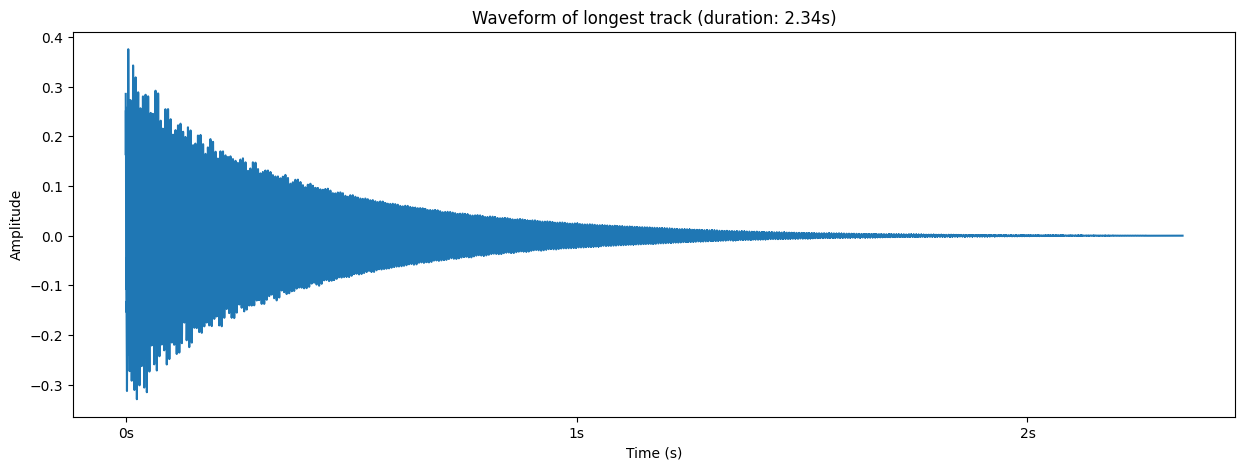

Track info:
Duration: 2.34s
Stroke name: bheem
Tonic: E


In [91]:
# Get the longest duration track
longest_idx = np.argmax(durations)
longest_track_id = track_ids[longest_idx]
longest_track = mridangam.track(longest_track_id)

# Load and display audio
x_long, sr_long = longest_track.audio

# calc time axis in seconds
xticks = np.arange(0, x_long.shape[-1], sr_long)
xtick_labels = [f"{i}s" for i in range(0, x_long.shape[-1] // sr_long + 1)]

# Plot waveform
plt.figure(figsize=(15, 5))
plt.plot(x_long)
plt.title(f'Waveform of longest track (duration: {durations[longest_idx]:.2f}s)')
plt.xticks(xticks, xtick_labels)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



print(f"Track info:")
print(f"Duration: {durations[longest_idx]:.2f}s")
print(f"Stroke name: {longest_track.stroke_name}")
print(f"Tonic: {longest_track.tonic}")

# Play the audio
ipd.Audio(x_long, rate=sr_long)

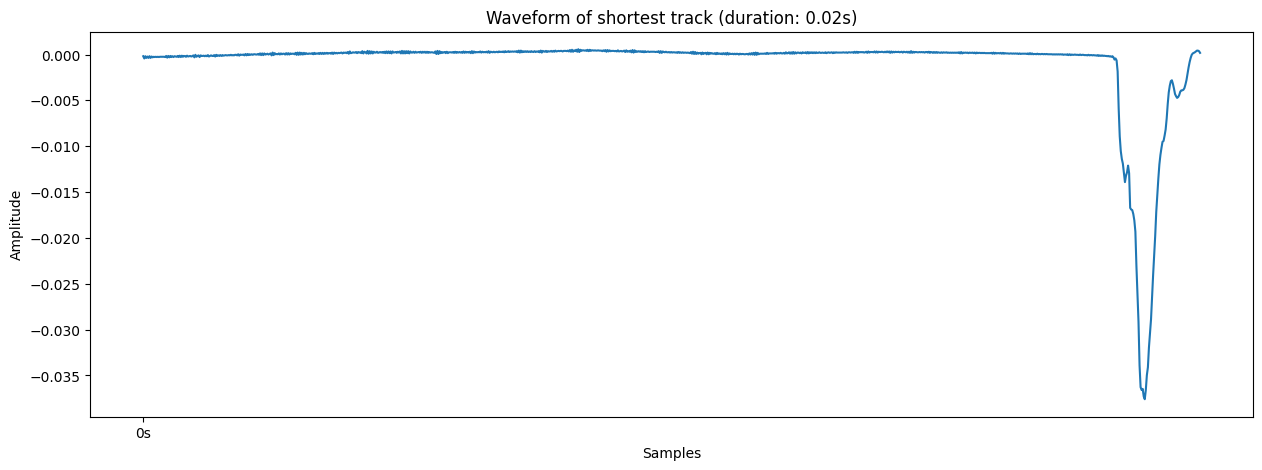

Track info:
Duration: 0.02s
Stroke name: thom
Tonic: D


In [ ]:
# Get the shortest duration track
shortest_idx = np.argmin(durations)
shortest_track_id = track_ids[shortest_idx]
shortest_track = mridangam.track(shortest_track_id)

# Load and display audio
x_short, sr_short = shortest_track.audio

# calc time axis in seconds
xticks = np.arange(0, x_short.shape[-1], sr_short)
xtick_labels = [f"{i}s" for i in range(0, x_short.shape[-1] // sr_short + 1)]

# Plot waveform
plt.figure(figsize=(15, 5))
plt.plot(x_short)
plt.title(f'Waveform of shortest track (duration: {durations[shortest_idx]:.2f}s)')
plt.xticks(xticks, xtick_labels)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

print(f"Track info:")
print(f"Duration: {durations[shortest_idx]:.2f}s")
print(f"Stroke name: {shortest_track.stroke_name}")
print(f"Tonic: {shortest_track.tonic}")

# Play the audio
ipd.Audio(x_short, rate=sr_short)

### Create Pytorch Dataset


In order to use this dataset with pytorch, we extend the Dataset object to load the audio and annotations in our dataset, according to the official pytorch tutorial [instructions](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

We basically need to write three methods:


*   __init__
*   __len__
*   __getitem__ to return each pair of audio array and class label


This is how a prototype of this class could look like:

```
class MridangamDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.track_ids = dataset.track_ids
    def __getitem__(self, index):
      # load data
      audio = load_audio(self.track_ids[index])
      label = self.track_ids[index].label
      # split audio in a fixed size array
      audio = audio[:seq_duration] 
      return audio,label
    def __len__(self):
      return len(self.tracks_ids)

```

For a good introduction to dataset loaders in the context of MIR see this tutorial [Deep Learning 101 for Audio based MIR](https://geoffroypeeters.github.io/deeplearning-101-audiomir_book/intro_pytorch.html)

Let's implement the class:



In [99]:
from torchcodec.decoders import AudioDecoder

class MridangamDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        mirdataset,
        seq_duration=0.5,
        random_start=True,
        resample=8000,
        subset=0,
        val_split = 0.1,
        test_split=0.1,
        random_seed=RANDOM_SEED
    ):
        self.seq_duration = seq_duration
        self.dataset = mirdataset
        self.track_ids = self.dataset.track_ids
        self.tracks = self.dataset.load_tracks()
        self.resample_rate = resample
        self.set = subset
        self.random_start = random_start

        # Build a list with labels 
        labels = [self.dataset.track(i).stroke_name for i in self.track_ids]
        unique_labels = list(set(labels)) # unique labels
        self.labels = {label:i for i,label in enumerate(unique_labels)}

        # Build the three subsets: train, validation, test using train_test_split, a stratified split with the labels
        # First split off the test set
        self.trackids_trainval, self.trackids_test = sklearn.model_selection.train_test_split(
            self.track_ids,
            test_size=test_split,
            random_state=random_seed,
            stratify=labels
        )

        # Now split train/val from the remaining data
        trainval_labels = [l for l, i in zip(labels, self.track_ids) if i in self.trackids_trainval]
        
        # Compute val fraction of the remaining data
        val_frac = val_split / (1 - test_split)
        self.trackids_train, self.trackids_valid = sklearn.model_selection.train_test_split(
            self.trackids_trainval,
            test_size=val_frac,
            random_state=random_seed,
            stratify=trainval_labels
        )

    def __getitem__(self, index):
        if self.set == 0:
            track_id = self.trackids_train[index]
        elif self.set == 1:
            track_id = self.trackids_valid[index]
        else:
            track_id = self.trackids_test[index]

        track = self.dataset.track(track_id)

        # Load full signal
        # We use AudioDecoder from torchcodec to avoid the warning produced by torchaudio.load
        # Please see this issue for the migration to torchcodec https://github.com/pytorch/audio/issues/3902
        decoder = AudioDecoder(source=track.audio_path, sample_rate=self.resample_rate)
        audio_signal = decoder.get_all_samples()
        sample_rate = decoder.metadata.sample_rate

        audio_signal = audio_signal.data
        # audio_signal, sample_rate = torchaudio.load(track.audio_path) # deprecated, uses torchcodedc internally and produces warning
        channels, total_samples = audio_signal.shape
        # duration = total_samples / sample_rate

        # Determine number of frames to extract
        num_frames = int(np.floor(self.seq_duration * sample_rate))
        if num_frames > total_samples:
            num_frames = total_samples

        # Optional random start
        offset = 0
        if self.random_start and num_frames < total_samples:
            max_offset = total_samples - num_frames
            offset = np.random.randint(0, max_offset)

        audio_segment = audio_signal[:, offset:offset + num_frames]

        # Zero pad if needed
        seq_duration_samples = int(self.seq_duration * sample_rate)
        pad_amount = seq_duration_samples - audio_segment.shape[-1]
        if pad_amount > 0:
            audio_segment = torch.nn.functional.pad(audio_segment, (0, pad_amount))

        # Resample TODO check if this is needed anymore since decoder can resample
        if sample_rate != self.resample_rate:
            "resampling from {} to {}".format(sample_rate, self.resample_rate)
            audio_segment = torchaudio.transforms.Resample(sample_rate, self.resample_rate)(audio_segment)

        return audio_segment, self.labels[track.stroke_name]

    def __len__(self):
        if self.set == 0:
            return len(self.trackids_train)
        elif self.set == 1:
            return len(self.trackids_valid)
        else:
            return len(self.trackids_test)



We initialize the dataset objects for train, validation, and test. We define the corresponding pytorch objects for data loading, defining the batch_size (paralellization on the GPU) and the num_workers ( data loading paralellization on CPU/memory).

In [ ]:
# Pytorch dataset loaders
train_dataset = MridangamDataset(mirdataset=mridangam, subset=0, random_seed=RANDOM_SEED)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=2, pin_memory=True)
valid_dataset = MridangamDataset(mirdataset=mridangam, subset=1, random_seed=RANDOM_SEED)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, num_workers=2, pin_memory=True)
test_dataset = MridangamDataset(mirdataset=mridangam, subset=2, random_seed=RANDOM_SEED)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, pin_memory=True)

We can have a look at the first batch from the training data to check it looks as expected. We convert the raw waveforms to mel spectrograms and visualise this. This will be the same input our model receives.

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


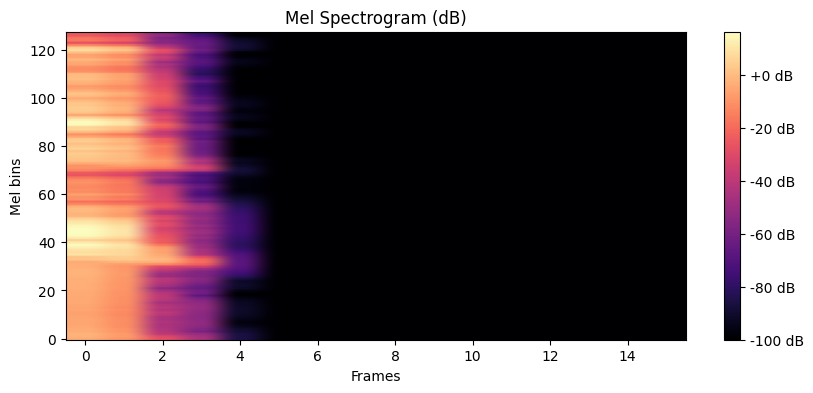

In [104]:
# Get a batch from the train_loader
batch = next(iter(train_loader))
waveform, label = batch  # waveform shape: (batch_size, channels, samples)

# Use the same mel-spectrogram transform as in model
melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=train_dataset.resample_rate, n_fft=1024, hop_length=256, n_mels=128
)
amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

# Compute mel spectrogram for the first sample in the batch
mel = melspec(waveform[0])
mel_db = amplitude_to_db(mel)

# Plot the mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_db.squeeze().cpu().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Mel Spectrogram (dB)')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
def plot_all_strokes_from_dataloader(
    dataloader,
    label_map,
    sample_rate=8000,
    n_fft=1024,
    hop_length=256,
    n_mels=128,
    seed=42,
):
    """
    Visualize one example per stroke by sampling batches directly from the dataloader.
    This shows what the model sees during training (cropped, padded, and normalized segments).
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Build inverse label map {index to stroke_name}
    inv_labels = {v: k for k, v in label_map.items()}
    num_strokes = len(label_map)

    # Mel-spectrogram transforms (same as done in CNN model)
    melspec = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    amp_to_db = torchaudio.transforms.AmplitudeToDB()

    # Collect one example per stroke
    chosen_examples = {}
    for batch in dataloader:
        waveforms, labels = batch  # (B, C, T), (B,)
        for waveform, lbl in zip(waveforms, labels):
            lbl = lbl.item()
            if lbl not in chosen_examples:
                chosen_examples[lbl] = waveform
            if len(chosen_examples) == num_strokes:
                break
        if len(chosen_examples) == num_strokes:
            break

    if len(chosen_examples) < num_strokes:
        print(f"Only found {len(chosen_examples)}/{num_strokes} strokes in dataloader.")

    # Plot one per stroke (sorted by label index)
    stroke_labels = sorted(chosen_examples.keys())
    n = len(stroke_labels)
    ncols = min(5, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3 * nrows))
    axes = np.array(axes).flatten()

    for ax, lbl in zip(axes, stroke_labels):
        waveform = chosen_examples[lbl]  # (C, T)
        if waveform.ndim == 2:
            waveform = waveform.mean(dim=0, keepdim=True)

        mel = melspec(waveform)
        mel_db = amp_to_db(mel)

        ax.imshow(mel_db[0].cpu().numpy(), origin='lower', aspect='auto', cmap='magma')
        ax.set_title(inv_labels[lbl], fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    for j in range(len(stroke_labels), len(axes)):
        axes[j].axis("off")

    fig.suptitle("One Example per Stroke (from DataLoader batches)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


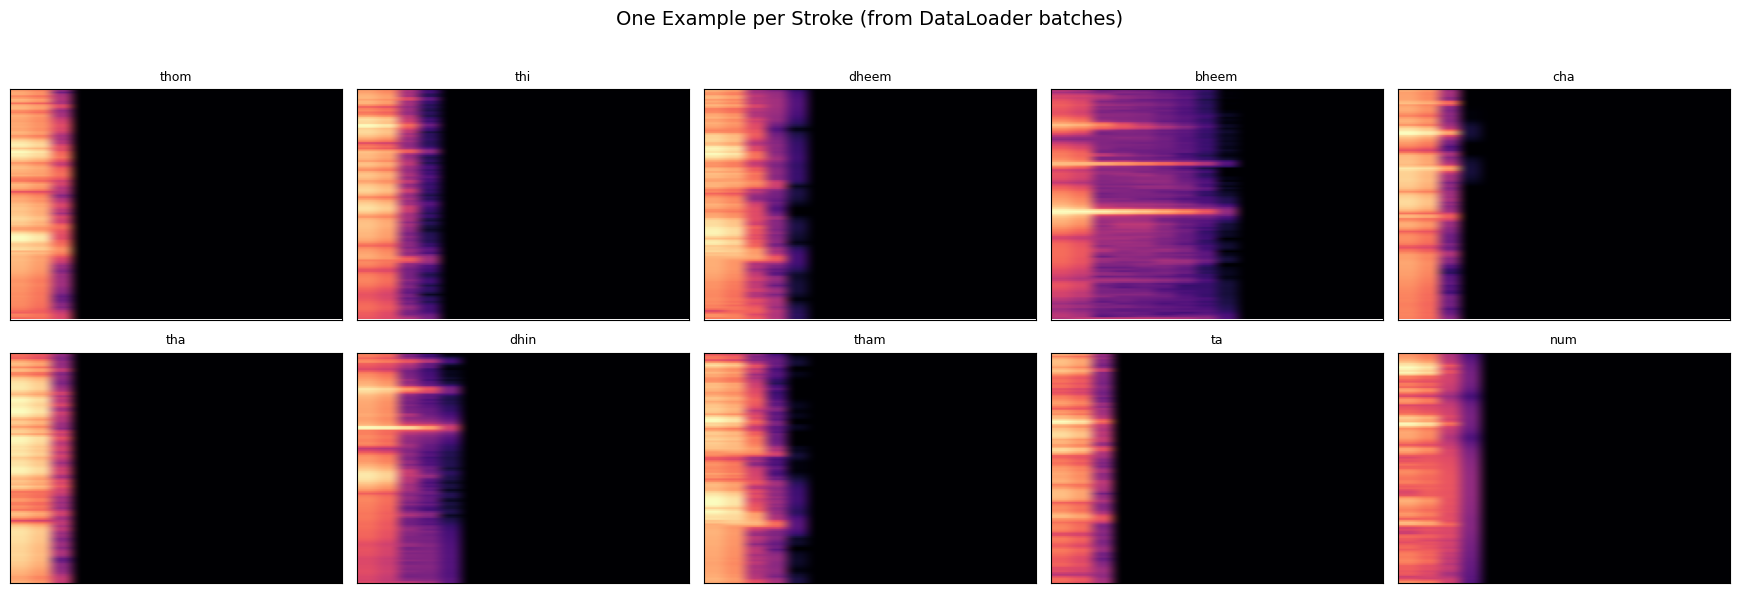

In [106]:
plot_all_strokes_from_dataloader(
    dataloader=train_loader,
    label_map=train_dataset.labels,
    sample_rate=train_dataset.resample_rate,
    n_fft=1024,
    hop_length=256,
    n_mels=128
)



**Which batch size/learning rate?**

Theory suggests that when multiplying the batch size by k, one should multiply the learning rate by sqrt(k) to keep the variance in the gradient expectation constant. See page 5 at A. Krizhevsky. One weird trick for parallelizing convolutional neural networks: https://arxiv.org/abs/1404.5997

However, recent experiments with large mini-batches suggest for a simpler linear scaling rule, i.e multiply your learning rate by k when using mini-batch size of kN. See P.Goyal et al.: Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour https://arxiv.org/abs/1706.02677

## Training a pytorch lightning classifier

We extend the pytorch lightning module according to the [documentation](https://lightning.ai/docs/pytorch/stable/model/train_model_basic.html). This may contain a definition of the layers in the neural network and how the data flows (how the layers are connected). You may overwrite other functions from `pl.LightningModule`, as described [here](https://lightning.ai/docs/pytorch/LTS/common/lightning_module.html). The most important are `training_step` and `configure_optimizers`, in which we define the training loss and the optimizers.

W = W - lr * Delta(W) -> Stochastic gradient descent
W = [w1 ... w10] [l1...l10] 

```
>>> class LitModel(pl.LightningModule):
...
...     def __init__(self):
...         super().__init__()
...         self.l1 = torch.nn.Linear(28 * 28, 10)
...
...     def forward(self, x):
...         return torch.relu(self.l1(x.view(x.size(0), -1)))
...
...     def training_step(self, batch, batch_idx):
...         x, y = batch
...         y_hat = self.forward(x)
...         loss = F.cross_entropy(y_hat, y)
...         return loss
...
...     def configure_optimizers(self):
...         return torch.optim.Adam(self.parameters(), lr=0.02)
```



We first build a Conv2D module which stacks several layers: 2D convolution, batch normalization, relu, maxpool, dropout

In [107]:
import torch.nn as nn

class ConvBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(ConvBlock, self).__init__()
        self .net = nn.Sequential( # We can use nn.Sequential to combine layers
            nn.Conv2d(input_channels, output_channels, shape, padding=shape//2),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
            nn.MaxPool2d(pooling),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x) # Pass through all layers in sequence

We predict the 10 classes of the Mridangam stroke dataset with a CNN using as input the mel-spectrograms computed from audio files.

In [ ]:
class CNN(pl.LightningModule):
    '''
    Simple CNN classification architecture: https://music-classification.github.io/tutorial/part3_supervised/tutorial.html
    '''
    def __init__(self, num_channels=16, 
                       sample_rate=8000, 
                       n_fft=1024, 
                       f_min=0.0, 
                       f_max=11025.0, 
                       num_mels=128, 
                       num_classes=10,
                       lr=1e-3,
                       dropout=0.5,
                       weight_decay=1e-4,
                       scheduler_name="none", T_max=30, max_lr_factor=5.0
                       ):
        super().__init__()
        
        self.save_hyperparameters() # saves hyperparameters to self.hparams

        self.celoss = torch.nn.CrossEntropyLoss()

        # Front-end feature extraction: mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            f_min=f_min, 
                                                            f_max=f_max, 
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

        # input batch normalization
        self.input_bn = torch.nn.BatchNorm2d(1)

        # convolutional layers
        self.features = nn.Sequential(
            ConvBlock(1, num_channels, pooling=(2, 2)),
            ConvBlock(num_channels, num_channels, pooling=(2, 2)),
            ConvBlock(num_channels, num_channels * 2, pooling=(2, 2)),
            ConvBlock(num_channels * 2, num_channels * 2, pooling=(3, 1)),
            ConvBlock(num_channels * 2, num_channels * 4, pooling=(3, 1))
        )

        # classification head with dense layers
        self.classifier = nn.Sequential(
            nn.Linear(num_channels * 4, num_channels * 4),
            nn.BatchNorm1d(num_channels * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(num_channels * 4, num_classes),
        )

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.valid_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_cm = torchmetrics.classification.ConfusionMatrix(task='multiclass', num_classes=num_classes)

    def forward(self, wav):
        # calculate mel spectrogram on the fly, in the GPU if available
        with torch.no_grad():
            out = self.melspec(wav)
            out = self.amplitude_to_db(out)
        out = self.input_bn(out)
        out = self.features(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

    def _shared_step(self, batch, stage):
        waveforms, labels = batch
        logits = self(waveforms)
        loss = self.celoss(logits, labels)
        preds = torch.argmax(logits, dim=1)
         
        # Get the correct metric object and update it
        metric = getattr(self, f"{stage}_acc")
        metric(preds, labels)
        
        # Log loss and accuracy. Using f-strings like "valid/loss" groups them in TensorBoard.
        self.log(f"{stage}/loss", loss, on_step=False, on_epoch=True, prog_bar=(stage != "test"))
        self.log(f"{stage}/acc", metric, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss, preds, labels

    def training_step(self, batch, batch_idx):
        loss, _, _ = self._shared_step(batch, "train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "valid")

    def test_step(self, batch, batch_idx):
        loss, preds, labels = self._shared_step(batch, "test")
        self.test_cm.update(preds, labels)
        return loss


    def get_progress_bar_dict(self):
        # don't show the version number
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items

	# TODO Do we keep the below implementation as the one we provide? 
	# and then the option that accepts hyperparameter tuning can be completed as a task or possible extension?
    # def configure_optimizers(self):
    #     optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=0.0001)
    #     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    #     return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )

        scheduler_name = getattr(self.hparams, "scheduler_name", "none")

        # Case 1: No scheduler
        if scheduler_name == "none":
            return optimizer

        # Case 2: Cosine Annealing
        elif scheduler_name == "cosine":
            T_max = getattr(self.hparams, "T_max", 30)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=T_max
            )
            return {"optimizer": optimizer, "lr_scheduler": scheduler}

        # Case 3: One Cycle
        elif scheduler_name == "onecycle":
            max_lr_factor = getattr(self.hparams, "max_lr_factor", 5.0)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.hparams.lr * max_lr_factor,
                total_steps=self.trainer.estimated_stepping_batches,
                anneal_strategy='cos',
                pct_start=0.3
            )
            # Important: OneCycleLR should update **every step**, not every epoch
            return {"optimizer": optimizer,
                    "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

        else:
            # fallback (shouldn't happen)
            return optimizer

We train the model defined above.

In [ ]:
# Initialize the model
model = CNN()

# Initialize a trainer
trainer = pl.Trainer(max_epochs=10, accelerator="auto")

# Train the model
trainer.fit(model, train_loader, valid_loader)

#Save the model
trainer.save_checkpoint('model_10epoch.ckpt')

Once the model is trained we can use it to process data, save it, get the metrics on the test set. 

In [ ]:
# Put the model in production
model.eval()

# Compute metrics on the test set
trainer.validate(dataloaders=test_loader)

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/am/Documents/upf_smc/mir_materials_internship/mir_course/notebooks/lightning_logs/version_8/checkpoints/epoch=29-step=2640.ckpt
Loaded model weights from the checkpoint at /home/am/Documents/upf_smc/mir_materials_internship/mir_course/notebooks/lightning_logs/version_8/checkpoints/epoch=29-step=2640.ckpt
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no acc

Validation DataLoader 0: 100%|██████████| 11/11 [00:01<00:00,  7.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         valid_acc         │    0.9183381199836731     │
│        valid_loss         │    0.2819417715072632     │
└───────────────────────────┴───────────────────────────┘

[{'valid_loss': 0.2819417715072632, 'valid_acc': 0.9183381199836731}]

In [77]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("lightning_logs", name="cnn_audio")
trainer = pl.Trainer(logger=logger)


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [ ]:
!tensorboard --logdir lightning_logs

## Hyperparameter tuning



In [ ]:
!pip install optuna
!pip install optuna-integration[pytorch_lightning]

In [ ]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import os
from lightning.pytorch.callbacks import ModelCheckpoint

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def objective(trial):
    # Core hyperparameters
    num_channels = trial.suggest_categorical("num_channels", [16, 32, 64])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    dropout = trial.suggest_uniform("dropout", 0.3, 0.6)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)

    # Scheduler choice
    scheduler_name = trial.suggest_categorical("scheduler_name", ["none", "cosine", "onecycle"])
    scheduler_params = {}
    if scheduler_name == "cosine":
        scheduler_params["T_max"] = trial.suggest_int("T_max", 10, 40)
    elif scheduler_name == "onecycle":
        scheduler_params["max_lr_factor"] = trial.suggest_uniform("max_lr_factor", 2.0, 8.0)

    # Model and checkpoint
    model = CNN(
        num_channels=num_channels,
        lr=lr,
        dropout=dropout,
        weight_decay=weight_decay,
        scheduler_name=scheduler_name,
        **scheduler_params
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="valid/acc",
        mode="max",
        save_top_k=1,
        dirpath=f"checkpoints/trial_{trial.number}",
        filename="best_model",
    )

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="auto",
        callbacks=[
            checkpoint_callback,
            PyTorchLightningPruningCallback(trial, monitor="valid/acc")
        ],
        enable_progress_bar=False,
        logger=False,
    )

    trainer.fit(model, train_loader, valid_loader)

    # Return best validation accuracy
    return trainer.callback_metrics["valid/acc"].item()


In [121]:
study = optuna.create_study(study_name="optimise_cnn", direction="maximize")
study.optimize(objective, n_trials=10)

print("Best trial:", study.best_trial.number)
print("Best value:", study.best_value)
print("Best params:", study.best_params)

# Load best model checkpoint
best_trial_dir = f"checkpoints/trial_{study.best_trial.number}"
best_model_path = os.path.join(best_trial_dir, "best_model.ckpt")

best_model = CNN.load_from_checkpoint(best_model_path)

[I 2025-10-17 10:37:47,524] A new study created in memory with name: optimise_cnn
/tmp/ipykernel_22938/2489743747.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/tmp/ipykernel_22938/2489743747.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.3, 0.6)
/tmp/ipykernel_22938/2489743747.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
/tmp/ipykernel_22938/2489743747

Best trial: 1
Best value: 0.922636091709137
Best params: {'num_channels': 64, 'lr': 0.00035490356137755864, 'dropout': 0.43635547775462025, 'weight_decay': 0.0009334261119469634, 'scheduler_name': 'cosine', 'T_max': 31}


Results of fine tuning:

In [ ]:
# Best trial: 1
# Best value: 0.922636091709137
# Best params: {'num_channels': 64, 'lr': 0.00035490356137755864, 'dropout': 0.43635547775462025, 'weight_decay': 0.0009334261119469634, 'scheduler_name': 'cosine', 'T_max': 31}

## Error Analysis

TODO briefly explain importance/purpose of error analysis and the task here

In [166]:
# Have a ook at the size of the test set adn the number of examples per class

# Size of the test set
test_size = len(test_dataset)
print(f"Test set size: {test_size}")

# Get all true labels in the test set
all_test_labels = []
for i in range(test_size):
  _, label = test_dataset[i]
  all_test_labels.append(label)
all_test_labels = np.array(all_test_labels)

# Map index to class name
idx_to_label = {v: k for k, v in train_dataset.labels.items()}
class_counts = {idx_to_label[i]: np.sum(all_test_labels == i) for i in range(len(idx_to_label))}

print("Number of examples per class in the test set:")
for cls, count in class_counts.items():
  print(f"{cls}: {count}")

Test set size: 698
Number of examples per class in the test set:
thom: 62
thi: 216
dheem: 45
bheem: 5
cha: 32
tha: 115
dhin: 47
tham: 36
ta: 92
num: 48


In [ ]:
# Load the model from the saved checkpoint
model = CNN.load_from_checkpoint("checkpoints/trial_9/best_model.ckpt")

# Put it in eval mode
model.eval()

# Create a new Trainer (no need for ckpt_path)
trainer = pl.Trainer(accelerator="auto")

# Validate
trainer.validate(model, dataloaders=test_loader)


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Validation DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 12.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         valid/acc         │    0.8911174535751343     │
│        valid/loss         │    0.3008565604686737     │
└───────────────────────────┴───────────────────────────┘

[{'valid/loss': 0.3008565604686737, 'valid/acc': 0.8911174535751343}]

First we should plot a confusion matrix 

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 12.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9111747741699219     │
│         test/loss         │    0.28745412826538086    │
└───────────────────────────┴───────────────────────────┘

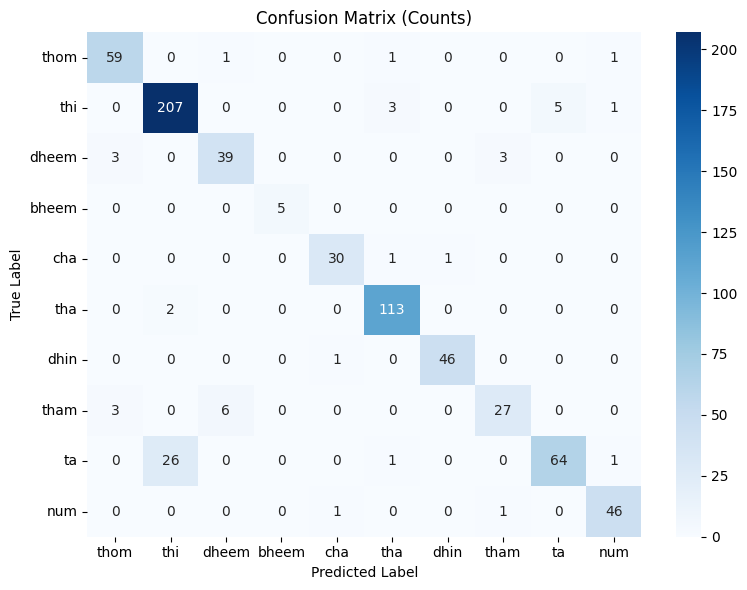

In [ ]:

def plot_confusion_matrix(model, class_names=None, normalize=False, figsize=(8, 6), cmap="Blues"):
    """
    Plot the confusion matrix stored in model.test_cm.

    Params:
        model: Trained LightningModule with self.test_cm (torchmetrics ConfusionMatrix)
        class_names (list[str]): Optional list of class names for axis labels
        normalize (bool): If True, normalize rows to percentages
        figsize (tuple): Size of the matplotlib figure
        cmap (str): Color map for seaborn heatmap
    """
    # Compute confusion matrix tensor
    cm = model.test_cm.compute().cpu().numpy()

    # Normalize by row (true class), if requested
    if normalize:
        cm = cm / cm.sum(axis=1, keepdims=True)
        fmt = ".2f"
        title = "Normalized Confusion Matrix"
    else:
        fmt = "d"
        title = "Confusion Matrix (Counts)"

    # Default class labels if none provided
    if class_names is None:
        class_names = [f"Class {i}" for i in range(cm.shape[0])]

    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


stroke_names = [k for k, v in sorted(train_dataset.labels.items(), key=lambda x: x[1])] # we reuse this

model.test_cm.reset() # otherwise it accumulates from previous test calls
trainer.test(model, dataloaders=test_loader)
plot_confusion_matrix(model, class_names=stroke_names, normalize=False)



In [150]:
print("Number of examples in test set:", len(test_loader.dataset))

total_cm = model.test_cm.compute()
print("Sum of confusion matrix counts:", total_cm.sum().item())  # Should match test set size


Number of examples in test set: 698
Sum of confusion matrix counts: 698


/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


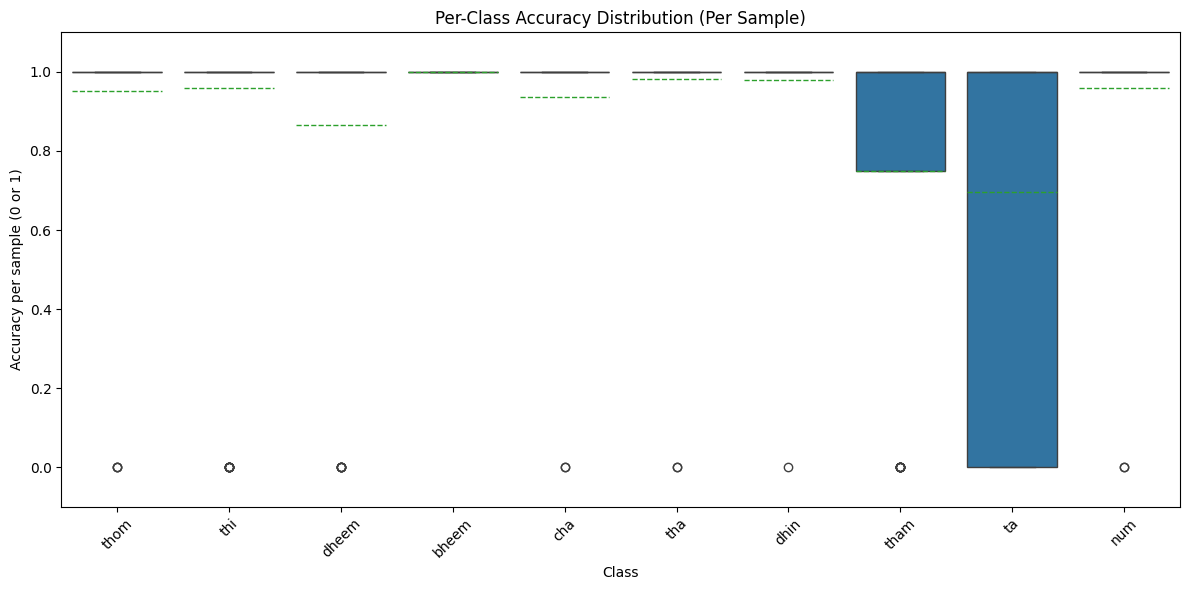

In [ ]:
def plot_per_sample_accuracy_boxplot(model, dataloader, class_names, device=None):
    """
    Plot per-sample accuracy as a boxplot for each class using Seaborn.
    
    Args:
        model: Trained PyTorch Lightning model
        dataloader: DataLoader for test set
        class_names: list of class names corresponding to label indices
        device: torch device (default: model device)
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    all_preds, all_labels = [], []

    # Collect predictions and labels
    with torch.no_grad():
        for waveforms, labels in dataloader:
            waveforms = waveforms.to(device)
            labels = labels.to(device)
            logits = model(waveforms)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Build per-sample accuracy lists for each class
    per_sample_acc = {name: [] for name in class_names}
    for true, pred in zip(all_labels, all_preds):
        class_name = class_names[true]
        per_sample_acc[class_name].append(int(pred == true))

    # Convert to long-format DataFrame for Seaborn
    data = []
    for cls_name, acc_list in per_sample_acc.items():
        for acc in acc_list:
            data.append({"Class": cls_name, "Accuracy": acc})
    df = pd.DataFrame(data)

    # Plot boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Class", y="Accuracy", data=df, showmeans=True, meanline=True)
    plt.xticks(rotation=45)
    plt.ylim(-0.1, 1.1)
    plt.ylabel("Accuracy per sample (0 or 1)")
    plt.title("Per-Class Accuracy Distribution (Per Sample)")
    plt.tight_layout()
    plt.show()
    
plot_per_sample_accuracy_boxplot(model, test_loader, class_names=stroke_names)



Lets listen to some of the specific errors per class

In [167]:
import torch
from IPython.display import display, Audio

def listen_to_class_errors(model, dataloader, target_class_name, class_names, sample_rate=8000, device=None, max_samples=None):
    """
    Play all misclassified samples of a given class in the test set and show predicted vs true.

    Params:
        model: Trained PyTorch Lightning model
        dataloader: DataLoader for test set
        target_class_name: string name of the class to inspect
        class_names: list of class names in order of their integer labels
        sample_rate: audio sample rate for playback
        device: torch device, defaults to model.device
        max_samples: maximum number of misclassified samples to play
    """
    if device is None:
        device = next(model.parameters()).device

    if target_class_name not in class_names:
        raise ValueError(f"target_class_name '{target_class_name}' not in class_names list!")

    target_class_idx = class_names.index(target_class_name)
    model.eval()

    errors_waveforms = []
    errors_preds = []

    with torch.no_grad():
        for waveforms, labels in dataloader:
            waveforms = waveforms.to(device)
            labels = labels.to(device)
            logits = model(waveforms)
            preds = torch.argmax(logits, dim=1)

            # Select misclassified samples of the target class
            mask = (labels == target_class_idx) & (preds != labels)
            if mask.any():
                errors_waveforms.append(waveforms[mask].cpu())
                errors_preds.append(preds[mask].cpu())

    if len(errors_waveforms) == 0:
        print(f"No misclassifications for class '{target_class_name}'!")
        return

    # Concatenate all misclassified waveforms and predictions
    errors_waveforms = torch.cat(errors_waveforms)
    errors_preds = torch.cat(errors_preds)

    if max_samples is not None:
        errors_waveforms = errors_waveforms[:max_samples]
        errors_preds = errors_preds[:max_samples]

    print(f"{errors_waveforms.shape[0]} misclassified examples for class '{target_class_name}'\n")

    # Play each misclassified sample with predicted vs true class
    for i, (waveform, pred_idx) in enumerate(zip(errors_waveforms, errors_preds)):
        print(f"Sample {i+1}: True = '{target_class_name}', Predicted = '{class_names[pred_idx]}'")
        display(Audio(waveform.squeeze().numpy(), rate=sample_rate))

listen_to_class_errors(best_model, test_loader, target_class_name="dheem", class_names=stroke_names, sample_rate=8000, max_samples=None)


/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


6 misclassified examples for class 'dheem'

Sample 1: True = 'dheem', Predicted = 'thom'


Sample 2: True = 'dheem', Predicted = 'tham'


Sample 3: True = 'dheem', Predicted = 'tham'


Sample 4: True = 'dheem', Predicted = 'thom'


Sample 5: True = 'dheem', Predicted = 'tham'


Sample 6: True = 'dheem', Predicted = 'thom'


Can you expain why these cases were predicetd as a different class?

__Task__

- Analyse the error cases, why is the model failing to predict these cases?


- Bheem is always misclassified (it is the smallest class in the overall dataset, it would be maybe a good task to have a task be to first visualise then adress the class inbalance here.)

- Extension that says - given your error analysis, what is the best way of improving the performance of the model?
	- data augmentation might be an effective method
	- as long as it is motivated correctly that should be fine.


## 💭 Questions

---

- Do different representations of audio improve performance?
  - You might explore different embeddings (VGGish, EnCodec) etc.

- Can the preprocessing be improved
  - Given the nature of the dataset is 0.5 seconds the best we can do?

## 💡 Possible Extensions
---
  
- Data augmentation strategies
  - for an introduction and some inspiration take a look at this tutorial https://music-classification.github.io/tutorial/part3_supervised/data-augmentation.html